In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import random
import math
import argparse

In [8]:
class SelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()
        self.hidden_size  = hidden_size 
        self.num_heads = num_heads 
        self.head_size = hidden_size // num_heads 

        #linear projections
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, hidden_size)
    def forward(self, x, past_kv = None, use_cache = False):
        bs, seq_len, _ = x.size()
        q = self.query(x).view(bs, seq_len, self.num_heads, self.head_size).transpose(1,2)
        k = self.key(x).view(bs, seq_len, self.num_heads, self.head_size).transpose(1,2)
        v = self.value(x).view(bs, seq_len, self.num_heads, self.head_size).transpose(1, 2)


        if past_kv is not None:
            past_k, past_v = past_kv
            k = torch.cat([past_k, k], dim = 2) #(4,4) + (1,4) = (5, 4) # shape(bs, num_heads, seq_len, head_size)
                                                #across seq_len 
            v = torch.cat([past_v, v], dim = 2) 

        attn_scores = torch.matmul(q, k.transpose(2, 3)) / (self.head_size**0.5)
        attn_weights = F.softmax(attn_scores, dim = -1) 
        context_vec = (attn_weights @ v).transpose(1, 2)
        context_vec = context_vec.contiguous().view(bs, seq_len, self.hidden_size)

        output = self.out(context_vec) #(bs, seq_len, hidden_size)

        if use_cache:
            return output, (k, v) # output (bs, seq_len, hidden_size) (k / v =(bs, num_heads, seq_len, head_size))
        return output 


In [16]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()
        self.attention = SelfAttention(hidden_size, num_heads)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.feed_forward = nn.Sequential(   #expansion - contarction
            nn.Linear(hidden_size, hidden_size*4),
            nn.GELU(),
            nn.Linear(hidden_size*4, hidden_size)
        )
    def forward(self, x, past_kv = None, use_cache = False):
        if use_cache:
            attn_output, new_kv = self.attention(self.norm1(x), past_kv, use_cache = True)
        else:
            attn_output = self.attention(self.norm1(x))
        x = x + attn_output #residual 
        x = x + self.feed_forward(self.norm2(x))  #(bs, seq_len, hidden_size)
        if use_cache:
            return x, new_kv
# class TransformerBlock(nn.Module):
    # def __init__(self, hidden_size, num_heads):
    #     super().__init__()
    #     self.attention = SelfAttention(hidden_size, num_heads)
    #     self.norm1 = nn.LayerNorm(hidden_size)
    #     self.norm2 = nn.LayerNorm(hidden_size)
    #     self.feed_forward = nn.Sequential(
    #         nn.Linear(hidden_size, hidden_size * 4),
    #         nn.GELU(),
    #         nn.Linear(hidden_size * 4, hidden_size)
    #     )
        
    # def forward(self, x, past_kv=None, use_cache=False):
    #     # Self-attention
    #     if use_cache:
    #         attn_output, new_kv = self.attention(self.norm1(x), past_kv, use_cache=True)
    #     else:
    #         attn_output = self.attention(self.norm1(x))
        
    #     # Residual connection
    #     x = x + attn_output
        
    #     # Feed forward
    #     x = x + self.feed_forward(self.norm2(x))
        
    #     if use_cache:
    #         return x, new_kv
        return x

In [17]:
class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_heads, num_layers):
      super().__init__()
      self.token_embeddings = nn.Embedding(vocab_size, hidden_size)
      self.position_embeddings = nn.Embedding(1024, hidden_size) # 1024 seq_len
      self.layers  = nn.ModuleList([
         TransformerBlock(hidden_size, num_heads) for _ in range(0, num_layers)
      ])
      self.norm = nn.LayerNorm(hidden_size)
      self.lm_head = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_ids, past_kvs = None, use_cache = False):
        bs, seq_len = input_ids.size()
        pos_ids = torch.arange(seq_len, dtype=torch.long, device=input_ids.device)
        pos_ids = pos_ids.unsqueeze(0).expand_as(input_ids)

        #get embeddings
        token_embeds = self.token_embeddings(input_ids)
        position_embeds = self.position_embeddings(pos_ids)
        hidden_states = token_embeds + position_embeds #(bs, seq_len, hidden_size)
        new_kvs = []
        if past_kvs is None and use_cache:
            past_kvs = [None] * len(self.layers)
        # Process through transformer layers
        for i, layer in enumerate(self.layers):
            if use_cache:
                hidden_states, new_kv = layer(hidden_states, past_kvs[i], use_cache=True)
                new_kvs.append(new_kv)
            else:
                hidden_states = layer(hidden_states)
        
        # Final norm and prediction
        hidden_states = self.norm(hidden_states)
        logits = self.lm_head(hidden_states)
        
        if use_cache:
            return logits, new_kvs #list of kvs having each element dimension (bs, num_heads, seq_len, head_size)
        return logits  #(bs, seq_len, vocab_size)
    
    def generate(self, input_ids, max_len, use_kv_cache = True):
        ''' generate text using the model with optional kv cache'''
        generated = input_ids.clone()
        past_kvs = None
        for i in range(max_len):
            if use_kv_cache:
                if past_kvs is not None:
                    current_input = generated[:, -1].unsqueeze(0)  #(bs, 1) here seq_len is 1
                else:
                    current_input = generated
                logits, past_kvs = self.forward(current_input, 
                                                past_kvs=past_kvs,
                                                use_cache=True
                                                ) 
            else:
                logits = self.forward(generated, use_cache=False)

            #get logits for the last token
            next_token_logits = logits[:, -1, :] 
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            generated = torch.cat([generated, next_token], dim = -1)
            
                
        return generated




Without KV Cache: 0.2647 seconds
With KV Cache: 0.1420 seconds
Speedup: 1.86x
Outputs match: False


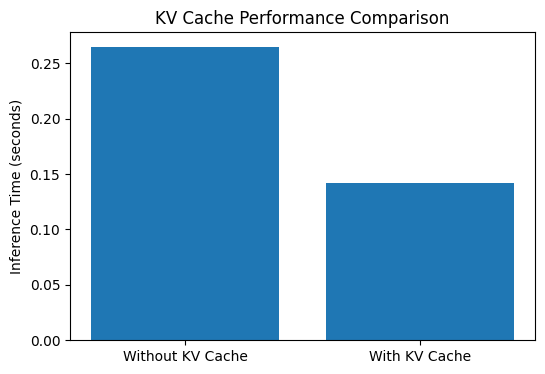

In [21]:
#testing the implementation
def benchmark_kv_cache():
    vocab_size = 10000
    hidden_size = 256
    num_heads = 4
    num_layers = 4 
    model = SimpleTransformer(vocab_size,
                              hidden_size,
                              num_heads,
                              num_layers
                              )
    model.eval()
    input_ids = torch.randint(0, vocab_size, (1, 10)) # (1, 10) 10 tensors
    #benchmark w/o kv cache
    start_time = time.time()
    output1 = model.generate(input_ids, max_len=50, use_kv_cache=False)
    no_cache_time = time.time() - start_time
    #benchmark kv cache
    start_time = time.time()
    output2 = model.generate(input_ids,max_len=50,use_kv_cache=True)
    with_cache_time = time.time() - start_time

    # Compare results
    print(f"Without KV Cache: {no_cache_time:.4f} seconds")
    print(f"With KV Cache: {with_cache_time:.4f} seconds")
    print(f"Speedup: {no_cache_time/with_cache_time:.2f}x")
    
    # Verify that outputs are identical (or close enough)
    print(f"Outputs match: {torch.all(output1 == output2)}")
    
    return no_cache_time, with_cache_time
# Run benchmark
no_cache_time, with_cache_time = benchmark_kv_cache()

# Plot results
plt.figure(figsize=(6, 4))
plt.bar(['Without KV Cache', 'With KV Cache'], [no_cache_time, with_cache_time])
plt.ylabel('Inference Time (seconds)')
plt.title('KV Cache Performance Comparison')
plt.show()



Sequence length 10:
  Without KV Cache: 0.0448 seconds
  With KV Cache: 0.0304 seconds
  Speedup: 1.47x
Sequence length 50:
  Without KV Cache: 0.2407 seconds
  With KV Cache: 0.1450 seconds
  Speedup: 1.66x
Sequence length 100:
  Without KV Cache: 0.5613 seconds
  With KV Cache: 0.2986 seconds
  Speedup: 1.88x
Sequence length 200:
  Without KV Cache: 1.4194 seconds
  With KV Cache: 0.5924 seconds
  Speedup: 2.40x
Sequence length 400:
  Without KV Cache: 3.9253 seconds
  With KV Cache: 1.2114 seconds
  Speedup: 3.24x


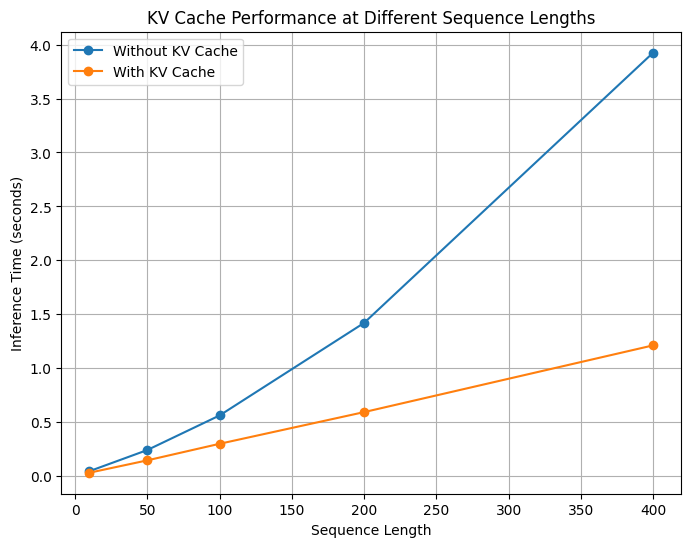

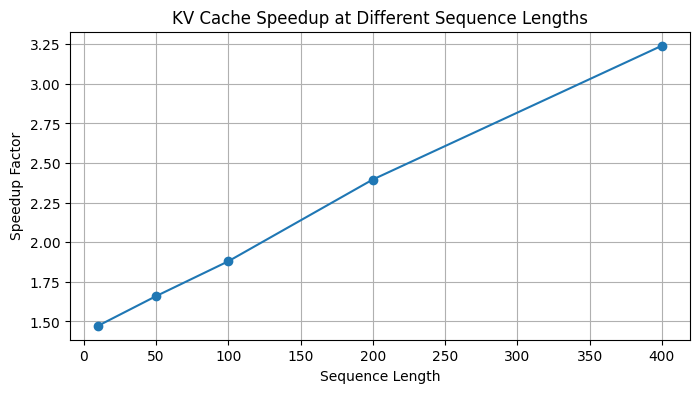

In [23]:
def benchmark_with_sequence_lengths():
    # Create a model
    vocab_size = 10000
    hidden_size = 256
    num_heads = 4
    num_layers = 4
    
    model = SimpleTransformer(vocab_size, hidden_size, num_heads, num_layers)
    model.eval()
    
    seq_lengths = [10, 50, 100, 200, 400]
    no_cache_times = []
    with_cache_times = []
    
    for seq_len in seq_lengths:
        # Initial input
        input_ids = torch.randint(0, vocab_size, (1, 5))
        
        # Generate sequence of length seq_len
        # Without KV cache
        start_time = time.time()
        model.generate(input_ids, max_len=seq_len, use_kv_cache=False)
        no_cache_time = time.time() - start_time
        no_cache_times.append(no_cache_time)
        
        # With KV cache
        start_time = time.time()
        model.generate(input_ids, max_len=seq_len, use_kv_cache=True)
        with_cache_time = time.time() - start_time
        with_cache_times.append(with_cache_time)
        
        print(f"Sequence length {seq_len}:")
        print(f"  Without KV Cache: {no_cache_time:.4f} seconds")
        print(f"  With KV Cache: {with_cache_time:.4f} seconds")
        print(f"  Speedup: {no_cache_time/with_cache_time:.2f}x")
    
    # Plot results
    plt.figure(figsize=(8, 6))
    plt.plot(seq_lengths, no_cache_times, 'o-', label='Without KV Cache')
    plt.plot(seq_lengths, with_cache_times, 'o-', label='With KV Cache')
    plt.xlabel('Sequence Length')
    plt.ylabel('Inference Time (seconds)')
    plt.title('KV Cache Performance at Different Sequence Lengths')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot speedup
    plt.figure(figsize=(8, 4))
    speedups = [n/w for n, w in zip(no_cache_times, with_cache_times)]
    plt.plot(seq_lengths, speedups, 'o-')
    plt.xlabel('Sequence Length')
    plt.ylabel('Speedup Factor')
    plt.title('KV Cache Speedup at Different Sequence Lengths')
    plt.grid(True)
    plt.show()
    
    return seq_lengths, no_cache_times, with_cache_times

# Run the benchmark
seq_lengths, no_cache_times, with_cache_times = benchmark_with_sequence_lengths()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F 

class RopelessMLA(nn.Module):
    def __init__(self, d_model, n_heads, kv_latent_dim):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads 
        self.dh  = d_model // n_heads 

        #linear projections
        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wdkv = nn.Linear(d_model, kv_latent_dim, bias=False)
        self.Wuk = nn.Linear(kv_latent_dim, d_model, bias=False)
        self.Wuv = nn.Linear(kv_latent_dim, d_model, bias=False)
        self.Wo = nn.Linear(d_model, d_model, bias = False) #logit matrix

        self.ln = nn.LayerNorm(kv_latent_dim)
        self.register_buffer('absorbed_k', None) # holds Wq @ Wuk

    def forward(self, x, kv_cache=None, past_length = 0):
        B, S, D = x.size() #batch, context length, dimension
        #compyte absorbed_k once : Wq @ Wuk.T shape (d_model, kv_laten_dim)
        if self.absorbed_k is None:
            absorbed = torch.matmul(self.Wq.weight , self.Wuk.weight) #(d_model, laten_dim)
            self.absorbed_k = absorbed.view(self.n_heads, self.dh, -1) #(n_heads, dh, latent_dim) group by multiple heads
        #compress  x into latent kv space 
        new_c_kv = self.ln(self.Wdkv(x)) #(BS, S, latent_dim)
        if kv_cache is None:
            c_kv = new_c_kv
        else:
            c_kv = torch.cat([kv_cache, new_c_kv], dim = 1) # B, s_total ( number of tokens infered uptil), latent_dim 
        S_full = c_kv.size(1)
        #decompress V to full d_model ans split into heads
        v_full  = self.Wuv(c_kv) #B, S_full, D 
        v = v_full.view(B, S_full, self.n_heads, self.dh).transpose(1, 2)

        #use input x directly ( W_q is absorbed)
        q = x.view(B, S, self.n_heads, self.dh) #(B, S, N_HEADS, DH)
        
        #compute attention scores
        attn_scores = torch.zeros(B, self.n_heads, S, S_full, device=x.device) 
        for h in range(self.n_heads):
            tmp = torch.matmul(q[:, :, h], self.absorbed_k[h]) #absorbed query vector
            attn_scores[:, h] = torch.bmm(tmp, c_kv.transpose(1,2)) #B, S, S_full

        attn_scores = attn_scores / (self.dh**0.5)
        mask = torch.tril(torch.ones((S, S_full), device=x.device), diagonal=past_length)
        attn_scores = attn_scores.masked_fill(mask.view(1, 1, S, S_full)==0, float('-inf'))
        attn_weights = F.softmax(attn_scores, dim=-1) #(B, N_heads, S, S_full)

        out_heads = []
        for h in range(self.n_heads):
            context_h = torch.matmul(attn_weights[:,h], v[:, h]) #B, S, dh
            out_heads.append(context_h)
        #concatenate all head out across feature dim
        out = torch.cat(out_heads, dim=-1) #(B, S, D)
        return self.Wo(out), c_kv





         
